# Speaker Identification in Keras

## Mikea Dimech

In [2]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pydub

from tensorflow import keras
from keras.preprocessing.image import img_to_array
from keras.preprocessing import *
from keras.models import Sequential
from keras.layers import *
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import *
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RepeatedKFold
from sklearn.metrics import *

## Part 1 - Data Pre-Processing

### Helper Functions

In [ ]:
def get_classes_in_data_path(datapath='./corpus'):
    subfolders = [f.path for f in os.scandir(datapath) if f.is_dir()]
    class_labels = np.arange(0,len(subfolders))

    return subfolders, class_labels


def get_wav_files_in_path(datapath):
    files = os.listdir(datapath)
    files_wav = [i for i in files if i.endswith('.wav')]

    return files_wav


def save_image(filepath, fig=None):
    """
    Save the current image with no whitespace to the given file path
    :param filepath: File path of PNG file to create
    :param fig: The matplotlib figure to save
    :return:
    """
    if not fig:
        fig = plt.gcf()

    plt.subplots_adjust(0, 0, 1, 1, 0, 0)
    for ax in fig.axes:
        ax.axis('off')
        ax.margins(0, 0)
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())
    fig.savefig(filepath, pad_inches=0, bbox_inches='tight')

### Feature Extraction: Obtaining MFCCs from the Audio Signal

In [ ]:
def get_mel_spectrogram(wavfile, n_mels=128, do_plot=False):
    """
    Given a path to a wav file, returns a Mel-spectrogram array,
    np.ndarray [shape=(n_mels,t)]
    :param wavfile: The input wav file path
    :param n_mels: The number of mel spectrogram filters
    :param do_plot: Flag to either plot the spectrogram or not (for debugging)
    :return: Returns a tuple of np.ndarray [shape=(n_mels,t)] and fs
    """

    #sig: time-domain signal
    #fs: sampling rate
    sig, fs = librosa.load(wavfile,sr=None)

    #normalise audio singal wihtin range [-1,1] by dividing signal by its maximum absolute value
    sig = sig / np.max(np.abs(sig))

    #set frame size accordingly to split file into chunks of 32ms
    mel_spec_frame_size = int(fs/32)

    #obtain mel spectogram
    melspec = librosa.feature.melspectrogram(y=sig,sr=fs,center=True,n_fft=mel_spec_frame_size,hop_length=int(mel_spec_frame_size/2),n_mels=n_mels)
    #convert power spectrum to decibel scale
    melspec = librosa.power_to_db(melspec,ref=1.0)

    #plot spectogram (for debugging purposes)
    if do_plot:
        display_melspec(melspec,fs,mel_spec_frame_size)

    return (melspec, fs)

def display_melspec(melspec,fs,mel_spec_frame_size):
    plt.figure(figsize=(10,5),dpi=150)
    plt.xlabel("Time")
    plt.ylabel("Mel-Frequency")
    librosa.display.specshow(melspec,y_axis="mel",fmax=fs/2,sr=fs,hop_length=int(mel_spec_frame_size/2),x_axis="time")
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.tight_layout()
    plt.show()
    plt.clf()
    return

def melspec_fig(mel_spectrogram):
    melspec = mel_spectrogram[0]
    fs = mel_spectrogram[1]
    mel_spec_frame_size = int(fs/32)
    plt.clf()
    ax = plt.figure(figsize=(5,5))
    librosa.display.specshow(melspec,fmax=fs/2,sr=fs,hop_length=int(mel_spec_frame_size/2))
    return ax

def chunk_save_spectogram(mel_spectrogram,output_path,n_mels):
    #we currently have a spectogram of nxm
    #obtain chunks of nxn
    
    n = len(mel_spectrogram[0][0])
    print("Current spectogram dimensions: ",mel_spectrogram[0].shape,sep="")
    print("Chunking into ",int(n/n_mels)," chunks of dimension ",n_mels,"x",n_mels,"...",sep="")
    #print("iterate for times ",int(n/n_mels))
    for i in range(int(n/n_mels)):
        #print(i+1,"/",int(n/n_mels))
        temp_arr = np.zeros((n_mels,n_mels))
        for j in range(n_mels):
            temp_arr[j] = mel_spectrogram[0][j][i*n_mels:(i+1)*n_mels]
        temp_fig = melspec_fig((temp_arr,mel_spectrogram[1]))
        save_image(output_path+str(i)+".png",fig=temp_fig)
        plt.close(temp_fig)

def pre_process_corpus(data_path,output_dir,n_mels):
    subfolders, class_labels = get_classes_in_data_path(data_path)
    for i, folder in enumerate(subfolders):
        files_wav = get_wav_files_in_path(folder)
        speaker = folder[-6:]
        print("\nprocessing speaker ",i+1,": ",speaker,"\n_________________",sep="")
        for wav in files_wav:
            full_path = folder+"\\"+wav
            passage_no = wav[12]
            output_path = output_dir+str(class_labels[i])+" - "+speaker+"\\"
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            output_path+=str(class_labels[i])+"_"+passage_no+"_"
            mel_spectogram = get_mel_spectrogram(full_path,n_mels=n_mels,do_plot=False)
            chunk_save_spectogram(mel_spectogram,output_path,n_mels=n_mels)
            print("file ",passage_no," complete\n",sep="")

### Sample Mel Spectrogram

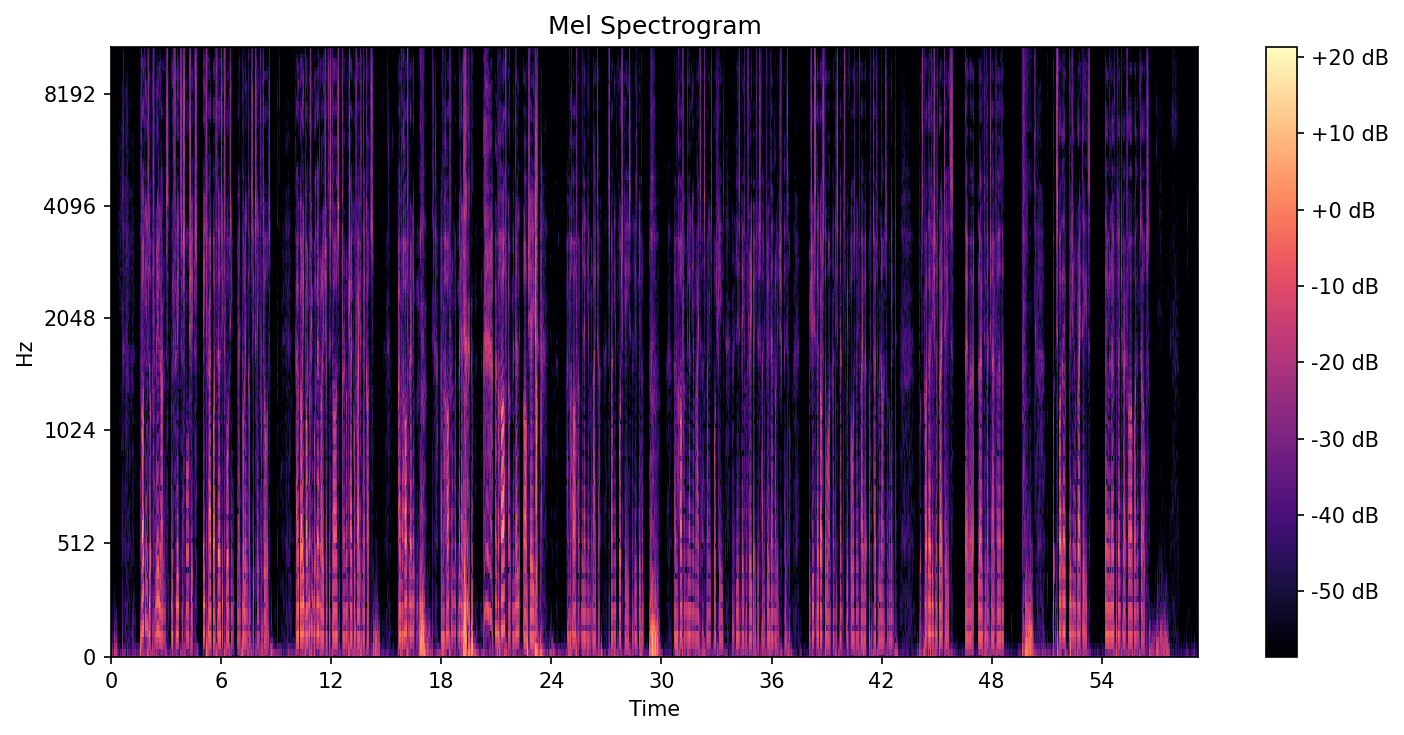

<Figure size 432x288 with 0 Axes>

In [ ]:
sample_path = "C:\\Users\\mikea\\OneDrive\\Documents\\University\\Third Year\\Units\\Speech Technology\\Assignment\\Speaker_Identification\\corpus\\ajh001\\shortpassageb_CT.wav"
sample_melspec = get_mel_spectrogram(sample_path,n_mels=128,do_plot=True)

### Pre-process Corpus

In [ ]:
data_path = "C:\\Users\mikea\\OneDrive\\Documents\\University\\Third Year\\Units\\Speech Technology\\Assignment\\Speaker_Identification\\corpus"
output_dir = "C:\\Users\\mikea\\OneDrive\\Documents\\University\\Third Year\\Units\\Speech Technology\\Assignment\\Task 1 Output\\"
n_mels = 128
pre_process_corpus(data_path,output_dir,n_mels)

## Part 2 - CNN Design, Training and Evaluation

### Initialise Pre-Processors and Load Data

In [3]:
class SimplePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize the image to a fixed size, ignoring the aspect
        # ratio
        return cv2.resize(image, (self.width, self.height),
                          interpolation=self.inter)

class ImageToArrayPreprocessor:
     def __init__(self, dataFormat=None):
          # store the image data format
          self.dataFormat = dataFormat

     def preprocess(self, image):
          # apply the Keras utility function that correctly rearranges
          # the dimensions of the image
          return img_to_array(image, data_format=self.dataFormat)

class DataLoader:
    def __init__(self, preprocessors=None):
        # store the image preprocessor
        self.preprocessors = preprocessors

        # if the preprocessors are None, initialize them as an
        # empty list
        if self.preprocessors is None:
            self.preprocessors = []

    def load(self, imagePaths, verbose=-1):
        # initialize the list of features and labels
        data = []
        labels = []

        # loop over the input images
        for (i, imagePath) in enumerate(imagePaths):
            # load the image and extract the class label assuming
            # that our path has the following format:
            # /path/to/dataset/{class}/{image}.jpg

            image = cv2.imread(imagePath)
            label = imagePath.split(os.path.sep)[-2]

            # check to see if our preprocessors are not None
            # if self.preprocessors is not None:
            # loop over the preprocessors and apply each to the image
            for p in self.preprocessors:
                image = p.preprocess(image)

            # treat our processed image as a "feature vector"
            # by updating the data list followed by the labels
            data.append(image)
            labels.append(label)

            # show an update every ‘verbose‘ images
            if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
                print("[INFO] processed {}/{}".format(i + 1, len(imagePaths)))

        # return a tuple of the data and labels
        return (np.array(data), np.array(labels))


### Get Image Paths

In [4]:
def get_classes_in_data_path(datapath='./corpus'):
    subfolders = [f.path for f in os.scandir(datapath) if f.is_dir()]
    class_labels = np.arange(0,len(subfolders))

    return subfolders, class_labels


def get_png_files_in_path(datapath):
    files = os.listdir(datapath)
    files_wav = [i for i in files if i.endswith('.png')]

    return files_wav

data_path = "C:\\Users\\mikea\\OneDrive\\Documents\\University\\Third Year\\Units\\Speech Technology\\Assignment\\Task 1 Output\\"


subfolders, class_labels = get_classes_in_data_path(data_path)
img_paths = []
for folder in subfolders:
    temp_imgs = get_png_files_in_path(folder)
    for img in temp_imgs:
        img_paths.append(folder+"\\"+img)

print("Image Paths (",len(img_paths)," total)\n__________________\n",sep="")
for path in img_paths:
    print(path)

Image Paths (1354 total)
__________________

C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_0.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_1.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_10.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_11.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_12.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_13.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech Technology\Assignment\Task 1 Output\0 - ajh001\0_a_14.png
C:\Users\mikea\OneDrive\Documents\University\Third Year\Units\Speech

In [4]:
#initialise image pre-processors
sp = SimplePreprocessor(32,32)
iap = ImageToArrayPreprocessor(dataFormat="channels_last")

#load dataset from disk and scale raw pizel intensities to range [0,1]
sdl = DataLoader(preprocessors=[sp,iap])
(data,labels) = sdl.load(imagePaths=img_paths, verbose=20)
data = data.astype("float")/255.0

#convert labels from images to vectors
# convert the labels from integers to vectors
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#one hot encode labels
#labels = to_categorical(labels)

[INFO] processed 20/1354
[INFO] processed 40/1354
[INFO] processed 60/1354
[INFO] processed 80/1354
[INFO] processed 100/1354
[INFO] processed 120/1354
[INFO] processed 140/1354
[INFO] processed 160/1354
[INFO] processed 180/1354
[INFO] processed 200/1354
[INFO] processed 220/1354
[INFO] processed 240/1354
[INFO] processed 260/1354
[INFO] processed 280/1354
[INFO] processed 300/1354
[INFO] processed 320/1354
[INFO] processed 340/1354
[INFO] processed 360/1354
[INFO] processed 380/1354
[INFO] processed 400/1354
[INFO] processed 420/1354
[INFO] processed 440/1354
[INFO] processed 460/1354
[INFO] processed 480/1354
[INFO] processed 500/1354
[INFO] processed 520/1354
[INFO] processed 540/1354
[INFO] processed 560/1354
[INFO] processed 580/1354
[INFO] processed 600/1354
[INFO] processed 620/1354
[INFO] processed 640/1354
[INFO] processed 660/1354
[INFO] processed 680/1354
[INFO] processed 700/1354
[INFO] processed 720/1354
[INFO] processed 740/1354
[INFO] processed 760/1354
[INFO] processed

### Data Splitting

In [5]:
#split data into training and test sets 
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, random_state=42)

### CNN - ShallowNet

In [6]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last"
        model = Sequential()
        inputShape = (height, width, depth)

        # if we are using "channels first", update the input shape
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)

        # define the first (and only) CONV => RELU layer
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Flatten())
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        model.summary()
        return model

In [7]:
n_epochs = 100
batch_size = 8
lr = 0.005

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=lr)
model = ShallowNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=batch_size, epochs=n_epochs, verbose=1)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
print("\nClassification Report\n__________________________")
print(classification_report(testY.argmax(axis=1),predictions.argmax(axis=1),target_names=lb.classes_))

[INFO] compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 20)                655380    
                                                                 
 activation_1 (Activation)   (None, 20)                0         
                                                                 
Total params: 656,276
Trainable params: 656,276
Non-trainable params: 0
_________________________________________________________________
[INFO] training network.

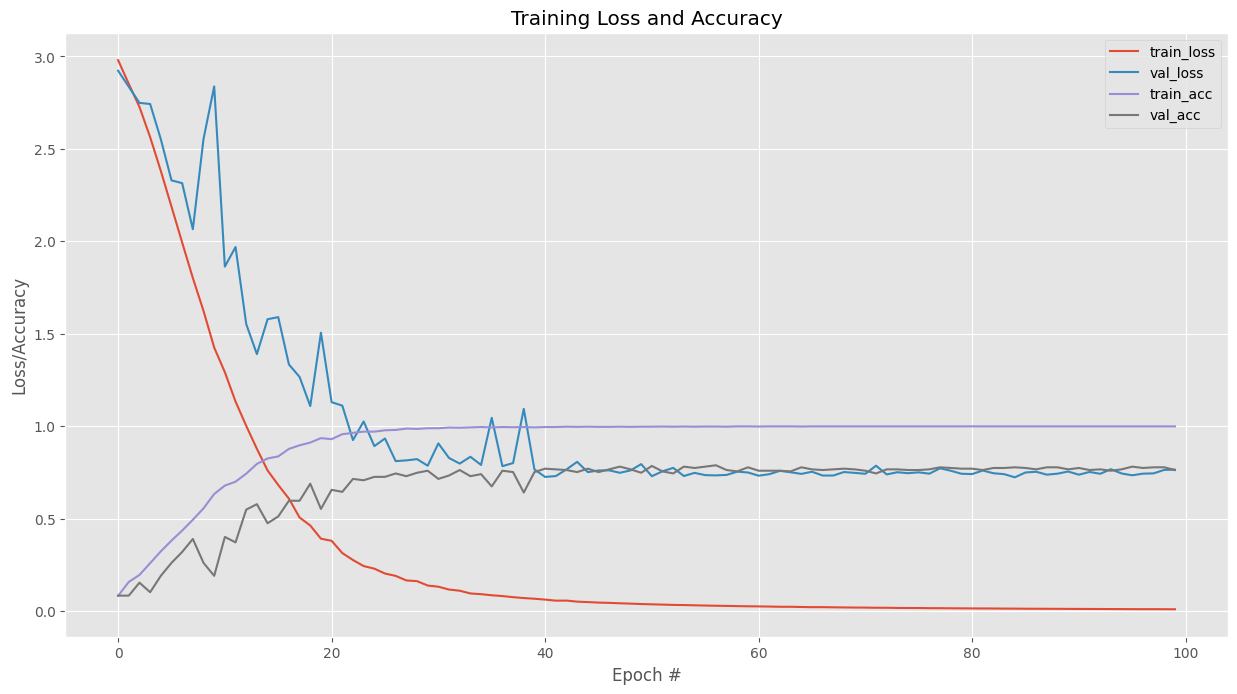

In [8]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15,8),dpi=100)
plt.plot(np.arange(0,n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### k-fold Cross Validation

In [9]:
k = 10
acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

inputs = np.concatenate((trainX, testX), axis=0)
targets = np.concatenate((trainY, testY), axis=0)

kfold = KFold(n_splits=k,shuffle=True,random_state=1)

fold_no=1
for train, test in kfold.split(inputs, targets):
    
    model = ShallowNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    H = model.fit(inputs[train], targets[train], validation_data=(inputs[test], targets[test]), batch_size=batch_size, epochs=n_epochs, verbose=1)   
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    predictions = model.predict(inputs[test])
    
    precision = precision_score(np.argmax(targets[test],axis=1), np.argmax(predictions,axis=1), average="macro")
    recall = recall_score(np.argmax(targets[test],axis=1), np.argmax(predictions,axis=1), average="macro")
    f1 = f1_score(np.argmax(targets[test],axis=1), np.argmax(predictions,axis=1), average="macro")
    print("_______________\nFold ",fold_no,"\n",model.metrics_names[0],": ",scores[0],"\n",model.metrics_names[1],": ",round(scores[1]*100,2),"%\nF1-score: ",f1,"\nPrecision: ",precision,"\nRecall: ",recall,"\n_______________",sep="")
    fold_no+=1

    acc_scores.append(scores[1])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

print("\n__________________\nAverage Score: ",round((sum(acc_scores)/k)*100,2),"%",sep="")
print("Average Precision: ",sum(precision_scores)/k,sep="")
print("Average Recall: ",sum(recall_scores)/k,sep="")
print("Average F1-scores: ",sum(f1_scores)/k,sep="")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_2 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_1 (Dense)             (None, 20)                655380    
                                                                 
 activation_3 (Activation)   (None, 20)                0         
                                                                 
Total params: 656,276
Trainable params: 656,276
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
153/153 [===========================

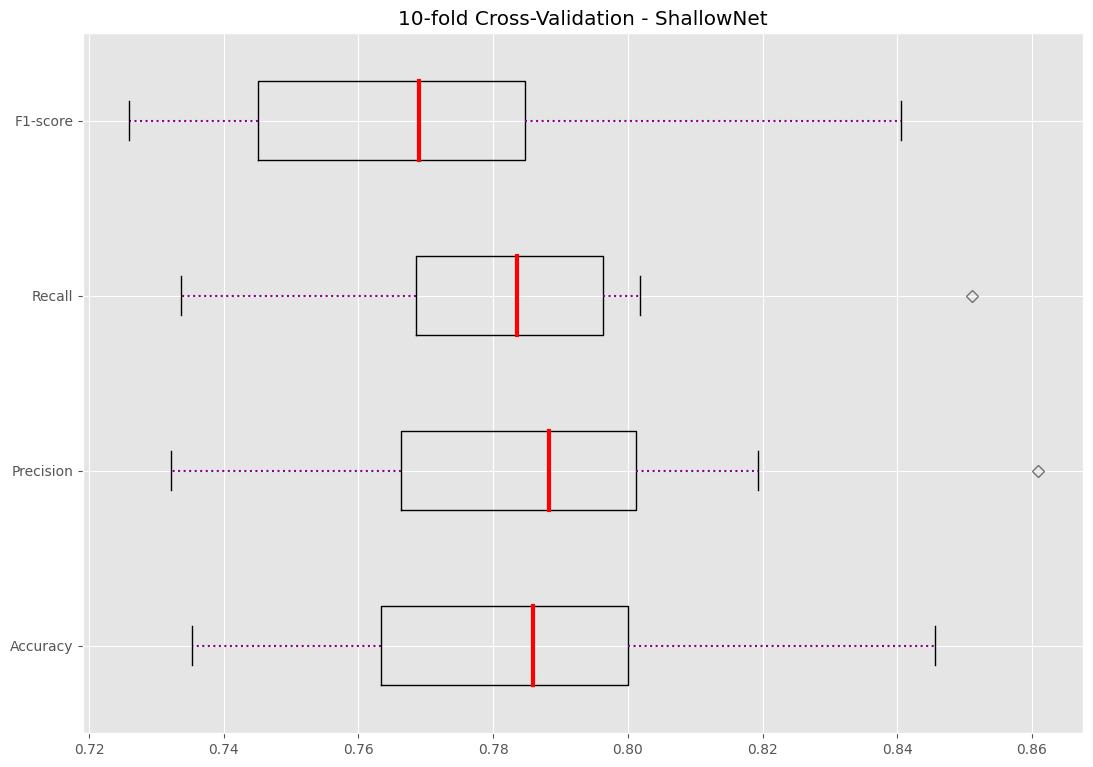

In [10]:
bp_data = [acc_scores,precision_scores,recall_scores,f1_scores]
fig = plt.figure(figsize=(10,7),dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(bp_data, patch_artist = False, vert = 0)
ax.set_yticklabels(['Accuracy', 'Precision','Recall', 'F1-score'])

for median in bp['medians']:
    median.set(color ='red',linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

plt.title("10-fold Cross-Validation - ShallowNet")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.show()

### CNN - Novel Network

In [6]:
class NovelNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last"
        model = Sequential()
        inputShape = (height, width, depth)
        model = Sequential()
        model.add(Conv2D(32,kernel_size=5,stride=2,padding='same',activation='relu',input_shape=inputShape))
        model.add(MaxPool2D())
        model.add(Dropout(0.4))
        model.add(Conv2D(64,kernel_size=5,stride=2,padding='same',activation='relu'))
        model.add(MaxPool2D())
        model.add(Dropout(0.4))
        model.add(Conv2D(128,kernel_size=3,stride=2,padding='same',activation='relu'))
        model.add(MaxPool2D(padding='same'))
        model.add(Dropout(0.4))
        model.add(Conv2D(128,kernel_size=3,stride=2,padding='same',activation='relu'))
        model.add(MaxPool2D())
        model.add(Conv2D(128,kernel_size=3,stride=2,padding='same',activation='relu'))
        model.add(MaxPool2D()) 
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(classes, activation='softmax'))
        return model



In [7]:
n_epochs = 500    #number of epochs
batch_size = 16   #training batch size
lr = 0.01         #learning rate
depth = 3         #depth of the network

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(learning_rate=lr)
model = NovelNet.build(32, 32, depth=depth, classes=len(lb.classes_))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
              batch_size=batch_size, epochs=n_epochs, verbose=1, callbacks=None)

# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=batch_size)
print(classification_report(testY.argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=lb.classes_))

[INFO] compiling model...
[INFO] training network...
Epoch 1/500
68/68 [==============================] - 3s 32ms/step - loss: 2.9984 - accuracy: 0.0600 - val_loss: 2.9939 - val_accuracy: 0.0738
Epoch 2/500
68/68 [==============================] - 2s 29ms/step - loss: 2.9951 - accuracy: 0.0499 - val_loss: 2.9922 - val_accuracy: 0.1070
Epoch 3/500
68/68 [==============================] - 2s 30ms/step - loss: 2.9915 - accuracy: 0.0757 - val_loss: 2.9904 - val_accuracy: 0.1144
Epoch 4/500
68/68 [==============================] - 2s 27ms/step - loss: 2.9899 - accuracy: 0.0711 - val_loss: 2.9891 - val_accuracy: 0.0886
Epoch 5/500
68/68 [==============================] - 2s 30ms/step - loss: 2.9899 - accuracy: 0.0720 - val_loss: 2.9878 - val_accuracy: 0.0886
Epoch 6/500
68/68 [==============================] - 2s 29ms/step - loss: 2.9852 - accuracy: 0.0785 - val_loss: 2.9867 - val_accuracy: 0.0886
Epoch 7/500
68/68 [==============================] - 2s 26ms/step - loss: 2.9851 - accuracy: 0.

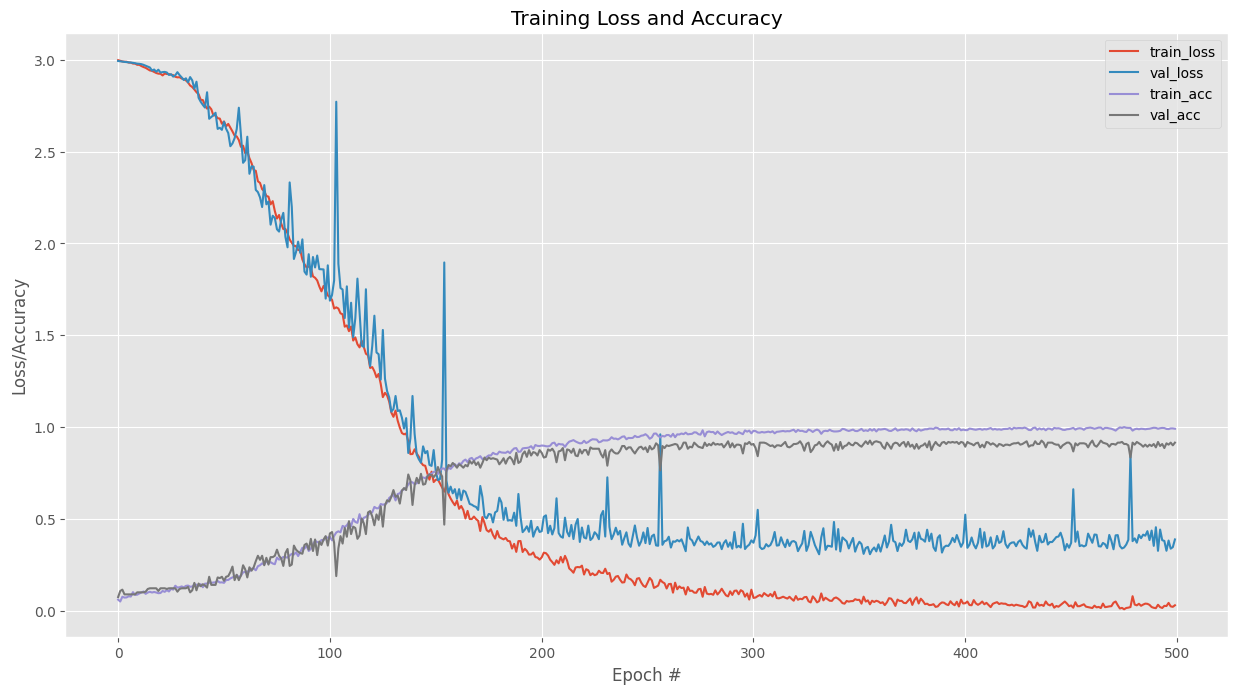

In [8]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure(figsize=(15,8),dpi=100)
plt.plot(np.arange(0,n_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,n_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,n_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,n_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

### k-fold Cross-Validation

In [9]:
k = 10
acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

inputs = np.concatenate((trainX, testX), axis=0)
targets = np.concatenate((trainY, testY), axis=0)

kfold = KFold(n_splits=k,shuffle=True,random_state=1)

fold_no=1
for train, test in kfold.split(inputs, targets):
    
    model = NovelNet.build(width=32, height=32, depth=3, classes=len(lb.classes_))
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    H = model.fit(inputs[train], targets[train], validation_data=(inputs[test], targets[test]), batch_size=batch_size, epochs=n_epochs, verbose=1)   
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    predictions = model.predict(inputs[test])
    
    precision = precision_score(np.argmax(targets[test],axis=1), np.argmax(predictions,axis=1), average="macro")
    recall = recall_score(np.argmax(targets[test],axis=1), np.argmax(predictions,axis=1), average="macro")
    f1 = f1_score(np.argmax(targets[test],axis=1), np.argmax(predictions,axis=1), average="macro")
    print("_______________\nFold ",fold_no,"\n",model.metrics_names[0],": ",scores[0],"\n",model.metrics_names[1],": ",round(scores[1]*100,2),"%\nF1-score: ",f1,"\nPrecision: ",precision,"\nRecall: ",recall,"\n_______________",sep="")
    fold_no+=1

    acc_scores.append(scores[1])
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

print("\n__________________\nAverage Score: ",round((sum(acc_scores)/k)*100,2),"%",sep="")
print("Average Precision: ",sum(precision_scores)/k,sep="")
print("Average Recall: ",sum(recall_scores)/k,sep="")
print("Average F1-scores: ",sum(f1_scores)/k,sep="")

Epoch 1/500
77/77 [==============================] - 2s 27ms/step - loss: 2.9991 - accuracy: 0.0411 - val_loss: 2.9966 - val_accuracy: 0.0515
Epoch 2/500
77/77 [==============================] - 2s 24ms/step - loss: 2.9932 - accuracy: 0.0452 - val_loss: 2.9953 - val_accuracy: 0.0662
Epoch 3/500
77/77 [==============================] - 2s 24ms/step - loss: 2.9890 - accuracy: 0.0567 - val_loss: 2.9948 - val_accuracy: 0.0662
Epoch 4/500
77/77 [==============================] - 2s 24ms/step - loss: 2.9924 - accuracy: 0.0649 - val_loss: 2.9942 - val_accuracy: 0.0662
Epoch 5/500
77/77 [==============================] - 2s 24ms/step - loss: 2.9902 - accuracy: 0.0755 - val_loss: 2.9932 - val_accuracy: 0.0662
Epoch 6/500
77/77 [==============================] - 2s 24ms/step - loss: 2.9856 - accuracy: 0.0747 - val_loss: 2.9931 - val_accuracy: 0.0662
Epoch 7/500
77/77 [==============================] - 2s 23ms/step - loss: 2.9846 - accuracy: 0.0895 - val_loss: 2.9919 - val_accuracy: 0.0662
Epoch 

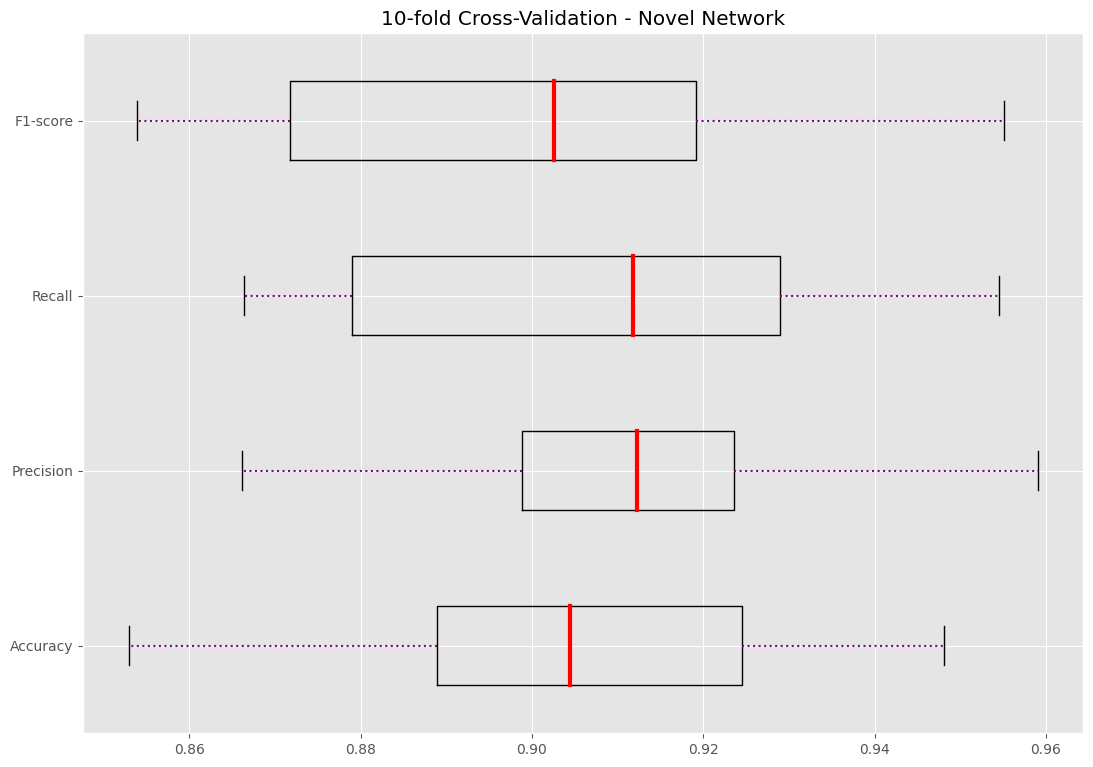

In [11]:
bp_data = [acc_scores,precision_scores,recall_scores,f1_scores]
fig = plt.figure(figsize=(10,7),dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(bp_data, patch_artist = False, vert = 0)
ax.set_yticklabels(['Accuracy', 'Precision','Recall', 'F1-score'])

for median in bp['medians']:
    median.set(color ='red',linewidth = 3)

for flier in bp['fliers']:
    flier.set(marker ='D',
              color ='#e7298a',
              alpha = 0.5)

for whisker in bp['whiskers']:
    whisker.set(color ='#8B008B',
                linewidth = 1.5,
                linestyle =":")

plt.title("10-fold Cross-Validation - Novel Network")
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.show()